# Prototype Version 1
This code will attempt to parse data from an mzML file, <b>visualize</b> a single spectra, <b>identify</b> the peaks and based on the distances between the peaks (which are assumed to be y-ions) <b>recognize</b> the amino acid sequence of the original peptide <br>
this will be done using the <b>DeNovo </b> approach presented by Nick Webb (https://www.weddslist.com/ms/tandem.html)

At the end, in order to check my results, I will use the pyteomics.pylab_aux module to test my annotations and visualize the annotated spectrum.

In [2]:
# basic dependencies and useful math/organization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# to read mzML files
from pyteomics import mzml

# to visualize mzML
from pyteomics import pylab_aux as pa, usi

# to find peaks
from scipy.signal import find_peaks
from peakutils import indexes

In [3]:
# open mzML file
file_path = 'data/2015-05-19_MRC5_a.mzML'

In [4]:
with mzml.MzML(file_path) as reader:
    for spectrum in reader:
        # Look for an MS/MS spectrum (ms level 2)
        if spectrum.get('ms level') == 2:
            print(spectrum["index"])
            # Extract relevant information
            mz_array = spectrum['m/z array']
            intensity_array = spectrum['intensity array']
            precursor_mz = spectrum['precursorList']['precursor'][0]['selectedIonList']['selectedIon'][0]['selected ion m/z']

            plotting_dict = {'m/z array': mz_array, 'intensity array': intensity_array}
            break


1


<Axes: xlabel='m/z', ylabel='intensity'>

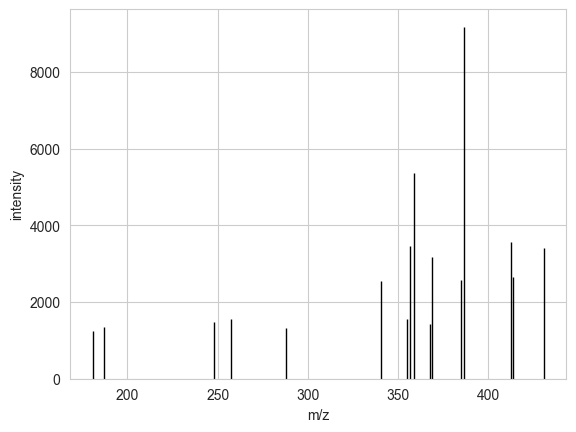

In [5]:
s1 = pd.DataFrame(plotting_dict)
pa.plot_spectrum(s1)

In [6]:
s1.head()

,m/z array,intensity array
0,180.776947,1240.152954
1,186.992432,1358.319824
2,247.723450,1477.135010
3,257.273926,1549.758423
4,287.695801,1326.091431


## finding peaks with scipy

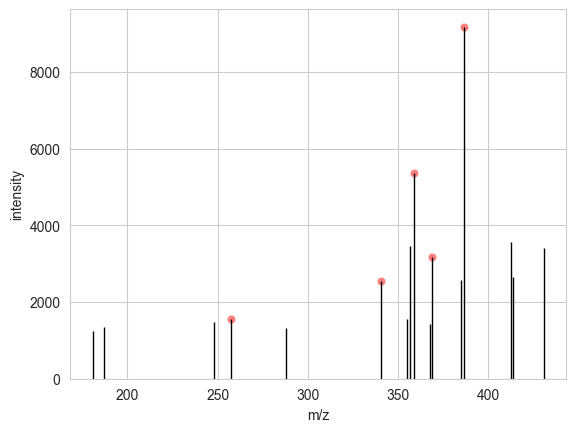

In [7]:
sp_height = None
sp_dist = None
sp_prom = None

sci_peak, _ = find_peaks(s1["intensity array"],
                      height=sp_height,
                      distance=sp_dist,
                      prominence=sp_prom
                      )
sns.scatterplot(data = s1.iloc[sci_peak].reset_index(),
                x = "m/z array",
                y = "intensity array",
                color = "red", alpha = 0.5)
pa.plot_spectrum(plotting_dict)
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [8]:
sci_peak

array([ 3,  5,  8, 10, 12], dtype=int64)

## finding peaks with peak utils

<Axes: xlabel='m/z', ylabel='intensity'>

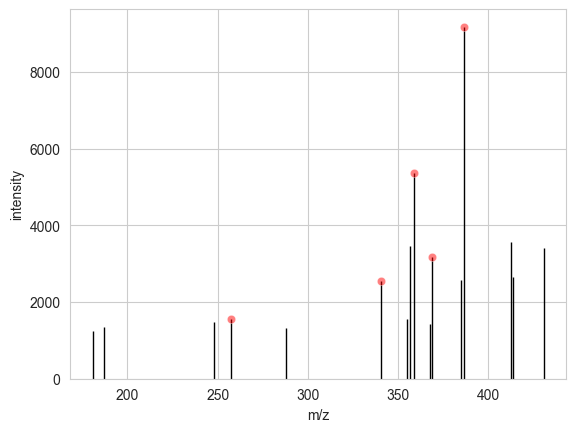

In [9]:
pu_mdist = 0
pu_thres_ = 0
util_peak = indexes(s1["intensity array"],
             min_dist=pu_mdist,
             thres=pu_thres_
             )
pa.plot_spectrum(plotting_dict)
sns.scatterplot(data = s1.iloc[util_peak],
                x = "m/z array",
                y = "intensity array",
                color = "red", alpha = 0.5)

## reading amino acids and their weight from csv

In [106]:
aa = pd.read_csv("data/amino_acids_with_weight.csv")

In [107]:
aa.head()

,full,letter,short,comp,mono mass,avg mass
0,glycine,G,GLY,C2H3NO,57.021464,57.05132
1,alanine,A,ALA,C3H5NO,71.037114,71.07790
2,serine,S,SER,C3H5NO2,87.032028,87.07730
3,proline,P,PRO,C5H7NO,97.052764,97.11518
4,valine,V,VAL,C5H9NO,99.068414,99.13106


In [108]:
combination_list = []
for mass1, aa1 in zip(aa["mono mass"],aa["letter"]):
    for mass2, aa2 in zip(aa["mono mass"],aa["letter"]):
        combination_list.append([mass1 + mass2,(aa1 + "+" + aa2)])

combo = pd.DataFrame(combination_list, columns =["c_mass","c_aa"])

In [109]:
combo.head()

,c_mass,c_aa
0,114.042927,G+G
1,128.058578,G+A
2,144.053492,G+S
3,154.074228,G+P
4,156.089878,G+V


In [12]:
precursor_mz

412.771563708782 m/z

In [13]:
s1["m/z array"].iloc[-1]

430.7792053222656

In [14]:
s1.iloc[sci_peak].reset_index()

,index,m/z array,intensity array
0,3,257.273926,1549.758423
1,5,340.798737,2547.850830
2,8,358.790039,5367.649902
3,10,368.775970,3170.719482
4,12,386.785583,9180.931641


In [16]:
prev_peak = precursor_mz
for i in range(1,3):
    # choose peak we want to assess distance to
    peak = s1.iloc[sci_peak].reset_index()["m/z array"].iloc[-i]
    dist = prev_peak - peak
    print("distance between: ", prev_peak, " and: ", peak, " is: ", dist)

    prev_peak = peak

distance between:  412.771563708782  and:  386.78558349609375  is:  25.985980212688276
distance between:  386.78558349609375  and:  368.7759704589844  is:  18.009613037109375


In [116]:
test_mass = 99

def find_closest_aa(aa_df, combo_df, value,thres = 5):
    closeness_list = []
    # find the closest single amino acids
    loop_for_single = True
    while loop_for_single:
        aam_array = np.asarray(aa_df["mono mass"])
        idx = (np.abs(aam_array - value)).argmin()
        error = np.abs(aam_array[idx] - value)
        name_idx = aa_df["letter"].iloc[idx]
        closeness_list.append([name_idx, aam_array[idx], error])
        aa_df = aa_df.drop(aa_df.index[idx])
        if error > thres:
            loop_for_single = False
    # find closest combination of amino acids
    loop_for_combo = True
    while loop_for_combo:
        aam_array = np.asarray(combo_df["c_mass"])
        idx = (np.abs(aam_array - value)).argmin()
        error = np.abs(aam_array[idx] - value)
        name_idx = combo_df["c_aa"].iloc[idx]
        closeness_list.append([name_idx, aam_array[idx], error])
        combo_df = combo_df.drop(combo_df.index[idx])
        if error > thres:
            loop_for_combo = False
    # print("closest aa is: ", name_idx, " ,with mass: ", aam_array[idx], "Da. With an error of: ", error, "Da.")
    return closeness_list

'''
I would love to decided a closeness factor by iterating over the weights
and seeing how close they are to each other on average. Does this make sense?
'''

'\nI would love to decided a closeness factor by iterating over the weights\nand seeing how close they are to each other on average. Does this make sense?\n'

In [117]:
find_closest_aa(aa,combo, test_mass)

[['V', 99.068413945, 0.0684139450000032],
 ['P', 97.052763875, 1.9472361250000034],
 ['T', 101.047678505, 2.0476785049999933],
 ['C', 103.009184505, 4.009184504999993],
 ['S', 87.032028435, 11.967971565],
 ['G+G', 114.04292747, 15.042927469999995]]

In [84]:
find_n_closest_combo(combo, test_mass)

[['G G', 114.04292747, 15.042927469999995],
 ['G A', 128.05857754, 29.058577539999987],
 ['A G', 128.05857754, 29.058577539999987],
 ['A A', 142.07422761, 43.07422761000001],
 ['G S', 144.05349217, 45.05349217]]

In [24]:
aa[aa["mono mass"] == aa["mono mass"][0]]

,full,letter,short,comp,mono mass,avg mass
0,glycine,G,GLY,C2H3NO,57.021464,57.05132
